In [10]:
%pip install spacy gensim --break-system-packages
%pip install --upgrade scipy gensim --break-system-packages
%pip install annoy --break-system-packages
%pip install qdrant_client --break-system-packages
!python3 -m spacy download en_core_web_sm --break-system-packages

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 631.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 942.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 411.0 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 987.4 kB/s eta 0:00:00 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.25.0 requires protobuf<5.0,>=3.19, but you have protobuf 5.27.2 which is incompatible.
N

In [26]:
import pandas as pd
import spacy
import faiss
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from annoy import AnnoyIndex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [24]:
file_path = 'dataset/full_dataset.csv'
df = pd.read_csv(file_path)

# Fill missing values with empty strings for text fields
df['title'] = df['title'].fillna('')
df['ingredients'] = df['ingredients'].fillna('')
df['directions'] = df['directions'].fillna('')

# Add columns for key characteristics
df['title_length'] = df['title'].apply(len)
df['ingredient_count'] = df['ingredients'].apply(lambda x: len(x.split(',')))
df['direction_length'] = df['directions'].apply(len)

# Stratified sampling
# First, we'll need to bin some continuous variables for stratification
df['title_length_bin'] = pd.qcut(df['title_length'], q=10, duplicates='drop')
df['ingredient_count_bin'] = pd.qcut(df['ingredient_count'], q=10, duplicates='drop')
df['direction_length_bin'] = pd.qcut(df['direction_length'], q=10, duplicates='drop')

# Perform stratified sampling
sampled_df = df.groupby(['title_length_bin', 'ingredient_count_bin', 'direction_length_bin'], group_keys=False).apply(lambda x: x.sample(frac=50000/len(df)))

# Reset index after sampling
sampled_df = sampled_df.reset_index(drop=True)

print(df.head())
print(df.info())

/var/folders/1d/hb016sss4n7f0rs9qdktfc_00000gn/T/ipykernel_66047/1527728918.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_df = df.groupby(['title_length_bin', 'ingredient_count_bin', 'direction_length_bin'], group_keys=False).apply(lambda x: x.sample(frac=50000/len(df)))


   Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com

/var/folders/1d/hb016sss4n7f0rs9qdktfc_00000gn/T/ipykernel_66047/1527728918.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(['title_length_bin', 'ingredient_count_bin', 'direction_length_bin'], group_keys=False).apply(lambda x: x.sample(frac=50000/len(df)))


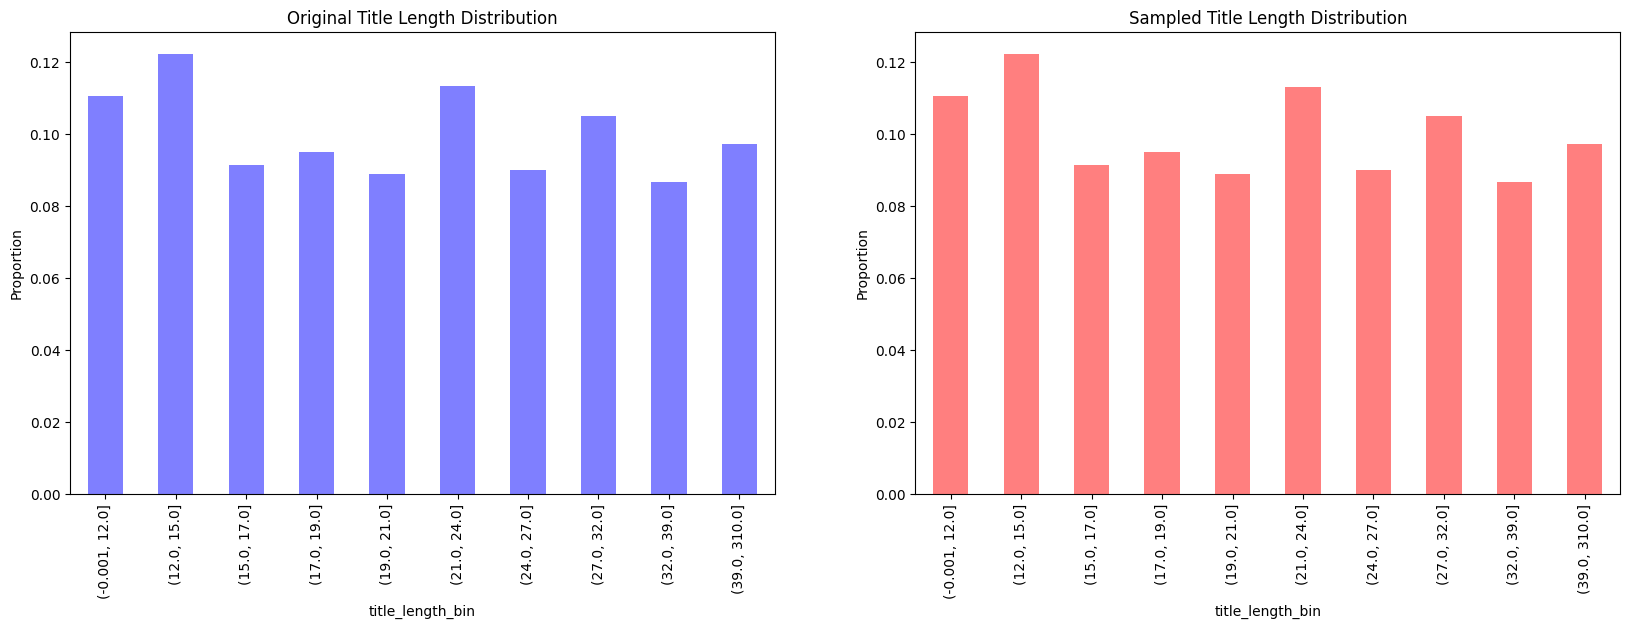

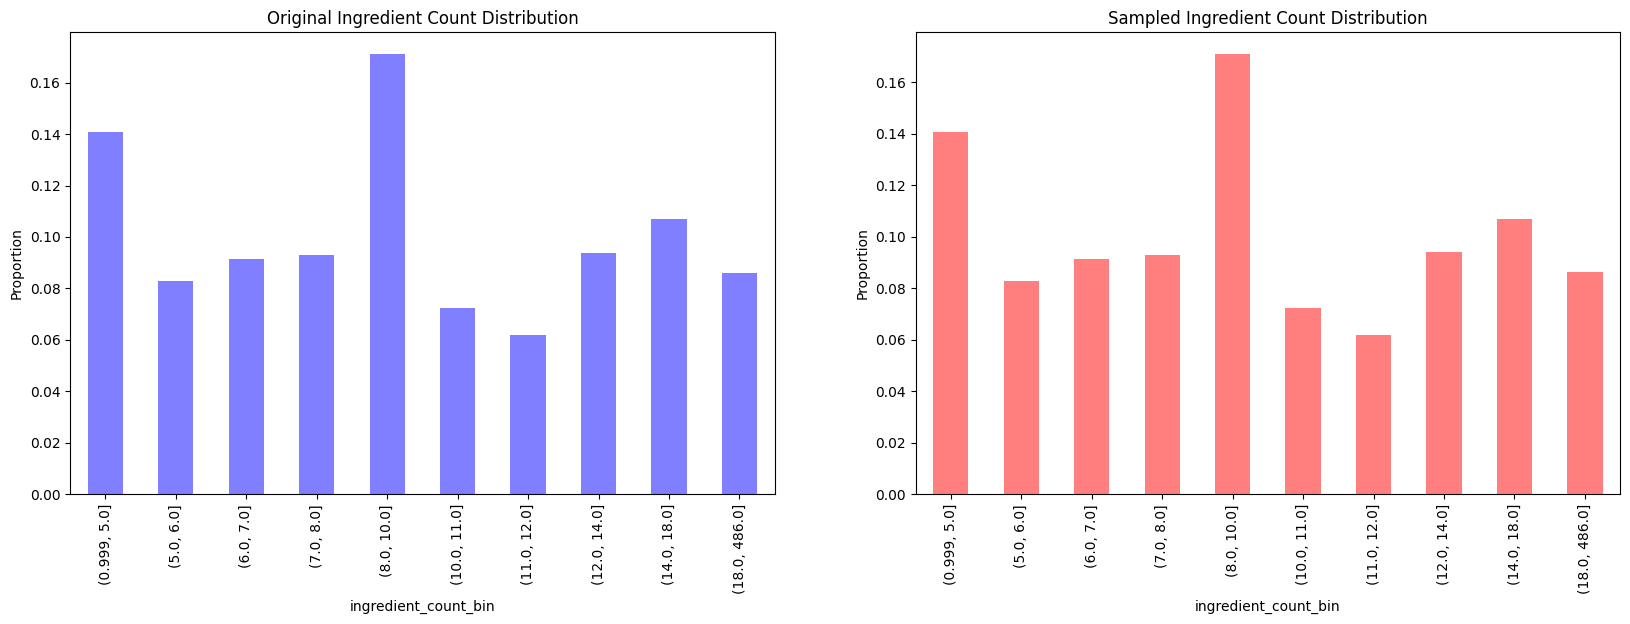

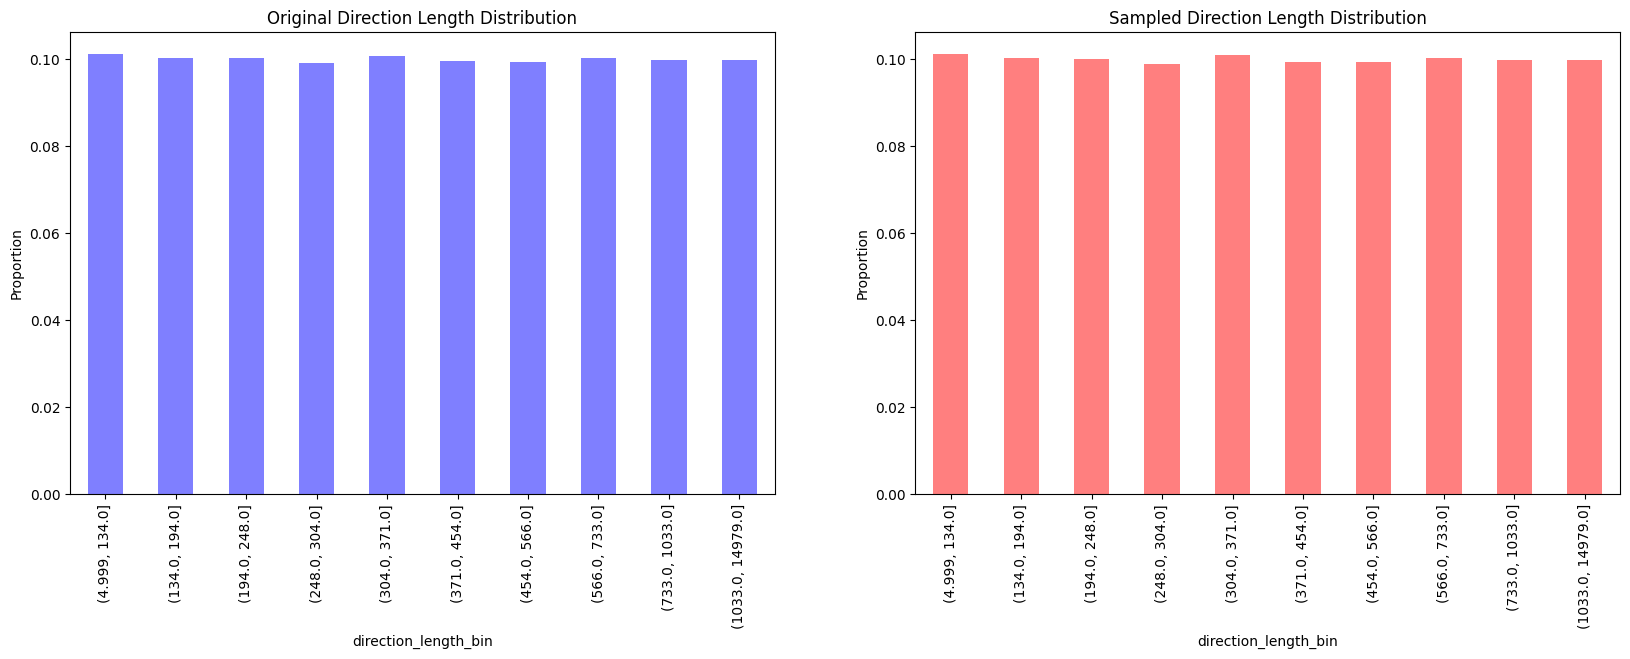

In [25]:
import matplotlib.pyplot as plt

# Function to compare distributions side by side
def plot_distribution_comparison_side_by_side(original, sampled, column, title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    original[column].value_counts(normalize=True).sort_index().plot(kind='bar', alpha=0.5, color='blue', ax=axes[0])
    axes[0].set_title(f'Original {title}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Proportion')
    
    sampled[column].value_counts(normalize=True).sort_index().plot(kind='bar', alpha=0.5, color='red', ax=axes[1])
    axes[1].set_title(f'Sampled {title}')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Proportion')
    
    plt.show()

# Compare distributions side by side
plot_distribution_comparison_side_by_side(df, sampled_df, 'title_length_bin', 'Title Length Distribution')
plot_distribution_comparison_side_by_side(df, sampled_df, 'ingredient_count_bin', 'Ingredient Count Distribution')
plot_distribution_comparison_side_by_side(df, sampled_df, 'direction_length_bin', 'Direction Length Distribution')

# Drop the temporary bin columns before saving
sampled_df = sampled_df.drop(columns=['title_length_bin', 'ingredient_count_bin', 'direction_length_bin'])

# Save the sampled dataset for further use
sampled_df.to_csv('sampled_recipes.csv', index=False)

In [35]:
file_path = 'sampled_recipes.csv'
sampled_df = pd.read_csv(file_path)

In [36]:
recipes = {}
for _, row in sampled_df.iterrows():
    recipes[row['title']] = {
        'directions': row['directions'],
        'ingredients': row['ingredients'],
        'NER': row['NER']
    }

In [37]:
nlp = spacy.load('en_core_web_sm')

In [38]:
# Function to create vector embeddings using TF-IDF
def embedding_function_tfidf(texts):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(texts).toarray()
    return vectors, vectorizer


# Prepare document embeddings using TF-IDF
corpus = [f"{data['NER']}" for data in recipes.values()]
document_vectors, vectorizer = embedding_function_tfidf(corpus)
titles = list(recipes.keys())

# Function to search the vector corpus
def search(query, k=10):
    # Create embedding for the query
    query_vec = vectorizer.transform([query]).toarray()
    
    # Calculate cosine similarity between query and document vectors
    similarities = cosine_similarity(query_vec, document_vectors)
    
    # Get top k results
    top_k_indices = similarities[0].argsort()[-k:][::-1]
    top_k_titles = [titles[i] for i in top_k_indices]
    
    return top_k_titles

# Example query
query = "chicken, olive oil, garlic"
results = search(query)

for r in results:
    print(f"Top recipes for query: {query} \nTitle: {r}, \nIngredients: {recipes[r]['ingredients']}, \nDirections: {recipes[r]['directions']}\n")



Top recipes for query: chicken, olive oil, garlic 
Title: Whole Roasted Garlic, 
Ingredients: ["1 head garlic", "1 tablespoon olive oil"], 
Directions: ["Preheat the oven to 375 degrees F.", "Cut the top third of the garlic head off so that the tops of the cloves are exposed.", "Place the garlic head, unpeeled, into a small ovenproof dish and drizzle with the oil.", "Cover with foil and bake for 30 minutes.", "Uncover and bake for 30 to 40 minutes more, until garlic is soft and golden brown.", "Serve with toasted bread."]

Top recipes for query: chicken, olive oil, garlic 
Title: Baked Spinach Chips, 
Ingredients: ["2 cups Baby Spinach Leaves", "1 Tablespoon Olive Oil", "1/4 teaspoons Garlic Powder", "Salt And Pepper, to taste"], 
Directions: ["Preheat the oven to 325 F.", "Combine the spinach and olive oil in a bowl and gently toss until all the leaves are coated.", "Lay them in a single row on a rimmed baking sheet that youve lined with parchment paper.", "Dont overlap the leaves.", 

In [49]:
from sklearn.metrics import ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Assuming `recipes` is a dictionary containing recipe data
# Sample recipes data (keys are titles, values are dictionaries with 'NER', 'ingredients', and 'directions')
recipes_example = {
    "Recipe1": {"NER": "olive oil, cilantro, tomatoes", "ingredients": "1 tbsp Olive oil, 3 tbsp Fresh Cilantro, Chopped, 1 pound Cherry Tomatoes", "directions": "Mix all ingredients."},
    "Recipe2": {"NER": "mayonnaise, pie crust, garlic", "ingredients": "1/2 cup mayonnaise, 1 baked 9 inch pie crust, 2 garlic cloves, crushed", "directions": "Combine and serve."},
    "Recipe3": {"NER": "sugar, soya sauce, oil", "ingredients": "1 1/2 tbsp Sugar, 2 tsp soya sauce, Frying oil", "directions": "Mix and fry."},
    "Recipe4": {"NER": "pork chops, peas, water", "ingredients": "2 lbs pork chops, 1/4 c. warm water, 1 pkg. frozen green peas, cooked", "directions": "Cook pork chops and peas."},
    "Recipe5": {"NER": "egg noodles, rice, olive oil", "ingredients": "6 cups egg noodles, cooked, 5 cups hot cooked rice, 1 tbsp olive oil", "directions": "Combine and serve."}
}

# Example queries and their relevant ground truth recipes
example_queries = [
    "olive oil, cilantro, tomatoes",
    "mayonnaise, pie crust, garlic",
    "sugar, soya sauce, oil",
    "pork chops, peas, water",
    "egg noodles, rice, olive oil"
]

# Ground truth relevant recipes (titles) for each query
ground_truths = {
    example_queries[0]: recipes_example["Recipe1"]["ingredients"],
    example_queries[1]: recipes_example["Recipe2"]["ingredients"],
    example_queries[2]: recipes_example["Recipe3"]["ingredients"],
    example_queries[3]: recipes_example["Recipe4"]["ingredients"],
    example_queries[4]: recipes_example["Recipe5"]["ingredients"]
}

# Function to calculate precision@k
def precision_at_k(results, ground_truth, k):
    relevant = set(ground_truth)
    retrieved = results[:k]
    relevant_retrieved = [doc for doc in retrieved if doc in relevant]
    return len(relevant_retrieved) / k

# Function to calculate recall@k
def recall_at_k(results, ground_truth, k):
    relevant = set(ground_truth)
    retrieved = results[:k]
    relevant_retrieved = [doc for doc in retrieved if doc in relevant]
    return len(relevant_retrieved) / len(relevant)


# Evaluate search results
def evaluate_search(example_queries, ground_truths, k=5):
    precisions = []
    recalls = []
    all_results = []
    all_similarities = []
    for query in example_queries:
        results = ""
        results_before = search(query)
        for r in results_before:
            results += recipes[r]['ingredients']
        all_results.append(results)
        ground_truth = ground_truths[query]
        
        precision = precision_at_k(results, ground_truth, k)
        recall = recall_at_k(results, ground_truth, k)
        
        precisions.append(precision)
        recalls.append(recall)
        
        print(f"Query: {query}")
        print(f"Results: {results}")
        print(f"Ground Truth: {ground_truth}")
        print(f"Precision@{k}: {precision:.2f}")
        print(f"Recall@{k}: {recall:.2f}")
        print()
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    
    print(f"Average Precision@{k}: {avg_precision:.2f}")
    print(f"Average Recall@{k}: {avg_recall:.2f}")

# Evaluate search function
evaluate_search(example_queries, ground_truths)


Query: olive oil, cilantro, tomatoes
Results: ["3 bunches cilantro", "1 bunch parsley", "1 cup olive oil", "1 teaspoon salt"]["1 (14.5 oz.) can diced tomatoes (undrained)", "1 (10 oz.) can diced tomatoes and green chilies (undrained)", "1 tsp. olive oil", "1/2 c. chopped onion", "2 garlic cloves, minced", "1 (8 oz.) block fat-free cream cheese, softened", "1 tsp. chili powder", "6 oz. light processed cheese, cubed (such as Velveeta Light)", "cilantro sprigs (optional)"]["3 cups cherry tomatoes", "1 small yellow onion, chunked", "1 jalapeno, seeded, topped, and minced", "2 tablespoons cilantro, roughly chopped", "2 tablespoons olive oil", "1 tablespoon lime juice", "2 garlic cloves, skinned and mashed", "salt"]["1 (15 ounce) can black beans, drained", "1 (10 ounce) can corn, drained", "1 tomatoes, chopped", "1/4 cup fresh cilantro, chopped", "1/8 cup red onion, chopped", "3 tablespoons lemon juice", "2 tablespoons olive oil", "salt", "pepper"]["4-5 medium tomatoes, chopped", "1 medium w